In [1]:
import os
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from itertools import combinations


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Import Consolidated Network Data

file_path = '/content/drive/My Drive/FinalSN1.csv'
finalsn1= pd.read_csv(file_path, encoding= 'latin', engine= 'python')

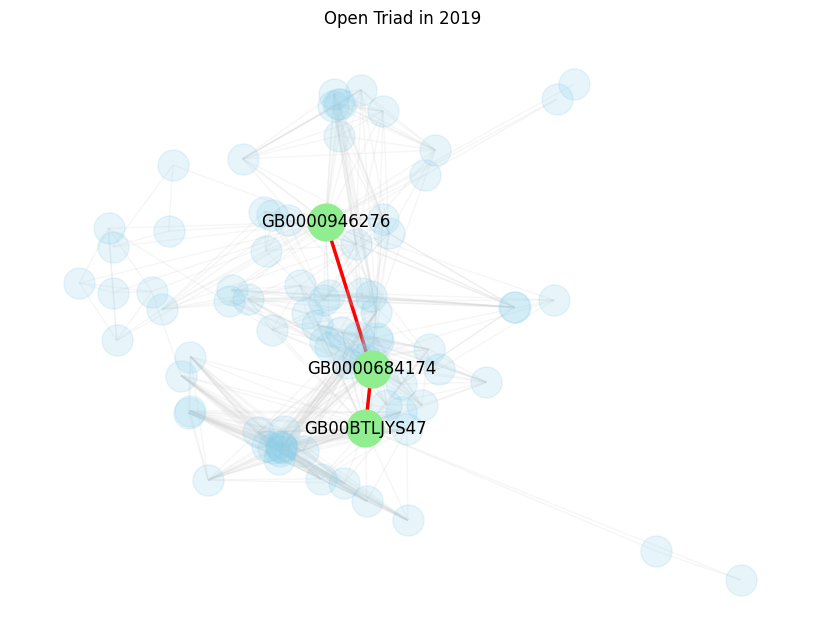

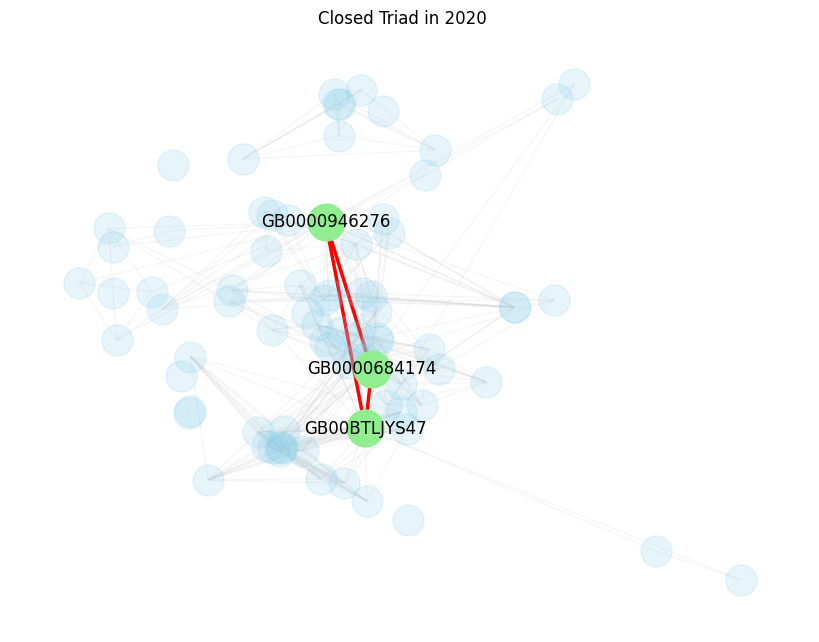

In [6]:
finalsn1['year'] = finalsn1['year'].astype(int)

# Pick 2 years
year_i = 2019
year_i1 = 2020

# Filter data for the current year and the next year
finalsn1_i = finalsn1[finalsn1['year'] == year_i]
finalsn1_i1 = finalsn1[finalsn1['year'] == year_i1]

# Create graph for the current year
G_current = nx.Graph()
for _, row in finalsn1_i.iterrows():
    G_current.add_edge(row['ISIN_x'], row['ISIN_y'], weight=row['Weight'])

# Create graph for the next year
G_next = nx.Graph()
for _, row in finalsn1_i1.iterrows():
    G_next.add_edge(row['ISIN_x'], row['ISIN_y'], weight=row['Weight'])

# Select a specific open triad for visualization
open_triads = []
for node in G_current.nodes():
    neighbors = list(G_current.neighbors(node))
    for u, v in combinations(neighbors, 2):
        if not G_current.has_edge(u, v):
            open_triads.append((u, v, node))

example_open_triad = open_triads[0]  # Replace with a specific example if desired
u, v, intermediary = example_open_triad

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_current)  # Positioning for visualization

# Draw the entire subgraph including the triad nodes and their neighbors
subgraph_nodes = list(G_current.neighbors(u)) + list(G_current.neighbors(v)) + [u, v, intermediary]
subgraph = G_current.subgraph(subgraph_nodes)

nx.draw(subgraph, pos, with_labels=False, node_color='skyblue', edge_color='lightgray', alpha=0.2, node_size=500)
nx.draw_networkx_edges(G_current, pos, edgelist=[(u, intermediary), (v, intermediary)], width=2.5, edge_color='red')
nx.draw_networkx_nodes(subgraph, pos, nodelist=[u, v, intermediary], node_color='lightgreen', node_size=700)
nx.draw_networkx_labels(subgraph, pos, labels={u: u, v: v, intermediary: intermediary})

plt.title(f"Open Triad in {year_i}   ")
plt.show()

# Visualization 2: Closed Triad (in year_i1)
plt.figure(figsize=(8, 6))

# Draw the closed triad and the same neighbors in the next year
subgraph_next = G_next.subgraph(subgraph_nodes)


nx.draw(subgraph_next, pos, with_labels=False, node_color='skyblue', edge_color='lightgray', alpha=0.2, node_size=500)
nx.draw_networkx_edges(G_next, pos, edgelist=[(u, intermediary), (v, intermediary), (u, v)], width=2.5, edge_color='red')
nx.draw_networkx_nodes(subgraph_next, pos, nodelist=[u, v, intermediary], node_color='lightgreen', node_size=700)
nx.draw_networkx_labels(subgraph_next, pos, labels={u: u, v: v, intermediary: intermediary})

plt.title(f"Closed Triad in {year_i1}   ")
plt.show()


In [7]:
closure_results = []
years = sorted(finalsn1['year'].unique())

# Iterate through each year
for i in range(len(years) - 1):
    year_i = years[i]
    year_i1 = years[i + 1]

    # Filter data for the current year and next year
    finalsn1_i = finalsn1[finalsn1['year'] == year_i]
    finalsn1_i1 = finalsn1[finalsn1['year'] == year_i1]

    # Create graph for the current year
    G_current = nx.Graph()
    for _, row in finalsn1_i.iterrows():
        G_current.add_edge(row['ISIN_x'], row['ISIN_y'], weight=row['Weight'])

    # Create graph for the next year
    G_next = nx.Graph()
    for _, row in finalsn1_i1.iterrows():
        G_next.add_edge(row['ISIN_x'], row['ISIN_y'], weight=row['Weight'])

    # Initialize counters
    P2 = C2 = 0
    P3 = C3 = 0
    P4 = C4 = 0

    # Count open abd closed paths (distance 2)
    for node in G_current.nodes():
        neighbors = list(G_current.neighbors(node))
        for u, v in combinations(neighbors, 2):
            if not G_current.has_edge(u, v):
                P2 += 1
                if G_next.has_edge(u, v):
                    C2 += 1

    # Count open and closed paths (distance 3)
    for node in G_current.nodes():
        neighbors_2 = set()
        for neighbor in G_current.neighbors(node):
            for second_neighbor in G_current.neighbors(neighbor):
                if second_neighbor != node and not G_current.has_edge(node, second_neighbor):
                    neighbors_2.add((node, second_neighbor))
        P3 += len(neighbors_2)
        for u, v in neighbors_2:
            if G_next.has_edge(u, v):
                C3 += 1

    # Count open and closed paths (distance 4)
    for node in G_current.nodes():
        neighbors_3 = set()
        for neighbor in G_current.neighbors(node):
            for second_neighbor in G_current.neighbors(neighbor):
                for third_neighbor in G_current.neighbors(second_neighbor):
                    if third_neighbor != node and not G_current.has_edge(node, third_neighbor):
                        neighbors_3.add((node, third_neighbor))
        P4 += len(neighbors_3)
        for u, v in neighbors_3:
            if G_next.has_edge(u, v):
                C4 += 1

    # Calculate closure ratios
    F2 = C2 / P2 if P2 > 0 else 0
    F3 = C3 / P3 if P3 > 0 else 0
    F4 = C4 / P4 if P4 > 0 else 0

    # Calculate Delta F
    Delta_F = F2 / F3 if F3 > 0 else float('inf')

    closure_results.append({
        'Yi': year_i,
        'Yi+1': year_i1,
        'P2': P2,
        'C2': C2,
        'F2': F2,
        'P3': P3,
        'C3': C3,
        'F3': F3,
        'P4': P4,
        'C4': C4,
        'F4': F4,
        'Delta F': Delta_F
    })

closure_results_df = pd.DataFrame(closure_results)



     Yi  Yi+1      P2    C2        F2      P3    C3        F3      P4    C4  \
0  2017  2018  193299  5163  0.026710  217080  3988  0.018371  911348  7266   
1  2018  2019  213640  4898  0.022926  230348  3924  0.017035  956764  6658   
2  2019  2020  212624  4366  0.020534  223646  3018  0.013495  900948  5168   
3  2020  2021  176512  3242  0.018367  196998  2630  0.013350  857340  5544   
4  2021  2022  194568  3781  0.019433  219958  3046  0.013848  984200  5512   
5  2022  2023  179295  3134  0.017480  205834  2426  0.011786  912666  4646   
6  2023  2024  145115  1523  0.010495  169918  1216  0.007156  749714  2186   

         F4   Delta F  
0  0.007973  1.453909  
1  0.006959  1.345835  
2  0.005736  1.521645  
3  0.006467  1.375767  
4  0.005600  1.403283  
5  0.005091  1.483055  
6  0.002916  1.466538  


In [8]:
closure_results_df

,Yi,Yi+1,P2,C2,F2,P3,C3,F3,P4,C4,F4,Delta F
0,2017,2018,193299,5163,0.026710,217080,3988,0.018371,911348,7266,0.007973,1.453909
1,2018,2019,213640,4898,0.022926,230348,3924,0.017035,956764,6658,0.006959,1.345835
2,2019,2020,212624,4366,0.020534,223646,3018,0.013495,900948,5168,0.005736,1.521645
3,2020,2021,176512,3242,0.018367,196998,2630,0.013350,857340,5544,0.006467,1.375767
4,2021,2022,194568,3781,0.019433,219958,3046,0.013848,984200,5512,0.005600,1.403283
5,2022,2023,179295,3134,0.017480,205834,2426,0.011786,912666,4646,0.005091,1.483055
6,2023,2024,145115,1523,0.010495,169918,1216,0.007156,749714,2186,0.002916,1.466538


In [10]:
results = []

# Iterate through each year
for i in range(len(years) - 1):
    year_i = years[i]
    year_i1 = years[i + 1]

    # Filter data for the current year and next year
    df_i = finalsn1[finalsn1['year'] == year_i]
    df_i1 = finalsn1[finalsn1['year'] == year_i1]

    # Create graph for the current year (Yi)
    G = nx.Graph()
    for _, row in df_i.iterrows():
        G.add_edge(row['ISIN_x'], row['ISIN_y'], weight=row['Weight'])

    # Create graph for the next year (Yi+1)
    G1 = nx.Graph()
    for _, row in df_i1.iterrows():
        G1.add_edge(row['ISIN_x'], row['ISIN_y'], weight=row['Weight'])

    # Initialize counts for P1 to P5
    P1 = P2 = P3 = P4 = P5 = 0
    pairs = {1: [], 2: [], 3: [], 4: [], 5: []}

    # Iterate over all pairs of nodes to find those at distance 2
    for u, v in combinations(G.nodes(), 2):
        if not G.has_edge(u, v):  # Check if they are not directly connected
            mutual_neighbors = len(list(nx.common_neighbors(G, u, v)))  # Count mutual connections (common neighbors)

            # Categorize the pair based on the number of mutual connections
            if mutual_neighbors == 1:
                P1 += 1
                pairs[1].append((u, v))
            elif mutual_neighbors == 2:
                P2 += 1
                pairs[2].append((u, v))
            elif mutual_neighbors == 3:
                P3 += 1
                pairs[3].append((u, v))
            elif mutual_neighbors == 4:
                P4 += 1
                pairs[4].append((u, v))
            elif mutual_neighbors >= 5:
                P5 += 1
                pairs[5].append((u, v))

    # Initialize counts for C1 to C5
    C1 = C2 = C3 = C4 = C5 = 0

    # Check for new connections in the next year (Yi+1)
    for key in pairs.keys():
        for u, v in pairs[key]:
            # Check if the pair formed a direct connection in the next year
            if G1.has_edge(u, v):
                if key == 1:
                    C1 += 1
                elif key == 2:
                    C2 += 1
                elif key == 3:
                    C3 += 1
                elif key == 4:
                    C4 += 1
                elif key == 5:
                    C5 += 1

    # Calculate empirical probabilities
    F1 = C1 / P1 if P1 > 0 else 0
    F2 = C2 / P2 if P2 > 0 else 0
    F3 = C3 / P3 if P3 > 0 else 0
    F4 = C4 / P4 if P4 > 0 else 0
    F5 = C5 / P5 if P5 > 0 else 0

    # Store the results for this year
    results.append({
        'Yi': year_i,
        'Yi+1': year_i1,
        'P1': P1, 'C1': C1, 'F1': F1,
        'P2': P2, 'C2': C2, 'F2': F2,
        'P3': P3, 'C3': C3, 'F3': F3,
        'P4': P4, 'C4': C4, 'F4': F4,
        'P5': P5, 'C5': C5, 'F5': F5
    })


results_df = pd.DataFrame(results)



     Yi  Yi+1     P1   C1        F1     P2   C2        F2     P3   C3  \
0  2017  2018  68619  866  0.012620  20028  405  0.020222   9354  246   
1  2018  2019  70224  840  0.011962  22228  419  0.018850  10201  280   
2  2019  2020  67079  554  0.008259  22399  370  0.016519   9765  167   
3  2020  2021  62961  539  0.008561  18328  338  0.018442   7815  159   
4  2021  2022  71432  675  0.009450  21227  318  0.014981   8143  234   
5  2022  2023  65762  492  0.007482  21130  268  0.012683   7802  174   
6  2023  2024  55071  234  0.004249  16963  162  0.009550   6438   75   

         F3    P4   C4        F4    P5   C5        F5  
0  0.026299  4723  172  0.036418  5816  305  0.052442  
1  0.027448  5533  153  0.027652  6988  270  0.038638  
2  0.017102  5418  126  0.023256  7162  292  0.040771  
3  0.020345  3838  122  0.031787  5557  157  0.028253  
4  0.028736  3976  108  0.027163  5201  188  0.036147  
5  0.022302  3728   99  0.026556  4495  180  0.040044  
6  0.011650  2942   62 

In [11]:
results_df

,Yi,Yi+1,P1,C1,F1,P2,C2,F2,P3,C3,F3,P4,C4,F4,P5,C5,F5
0,2017,2018,68619,866,0.012620,20028,405,0.020222,9354,246,0.026299,4723,172,0.036418,5816,305,0.052442
1,2018,2019,70224,840,0.011962,22228,419,0.018850,10201,280,0.027448,5533,153,0.027652,6988,270,0.038638
2,2019,2020,67079,554,0.008259,22399,370,0.016519,9765,167,0.017102,5418,126,0.023256,7162,292,0.040771
3,2020,2021,62961,539,0.008561,18328,338,0.018442,7815,159,0.020345,3838,122,0.031787,5557,157,0.028253
4,2021,2022,71432,675,0.009450,21227,318,0.014981,8143,234,0.028736,3976,108,0.027163,5201,188,0.036147
5,2022,2023,65762,492,0.007482,21130,268,0.012683,7802,174,0.022302,3728,99,0.026556,4495,180,0.040044
6,2023,2024,55071,234,0.004249,16963,162,0.009550,6438,75,0.011650,2942,62,0.021074,3545,75,0.021157
